<a href="https://colab.research.google.com/github/daniilprigozhin/Soy_NLRome/blob/main/Soy_CladeFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##This block takes 4-5 minutes
import pandas as pd
import numpy as np
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bioconda hmmer 
!conda install -c bioconda mafft

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...
Solving environment: - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - hmmer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    conda-4.11.0               |   py37h89c1867_0        16.9 MB  conda-forge
    hmmer-3.3.2                |       h1b792b2_1         9.6 MB  bioconda
    ------------------------------------------------------------
                                           Total:        26.8 MB

The following NEW packages will be IN

In [ ]:
%rm -rf Soy_NLRome/
!git clone https://github.com/daniilprigozhin/Soy_NLRome.git
!ls

Cloning into 'Soy_NLRome'...
remote: Enumerating objects: 3636, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 3636 (delta 1), reused 3 (delta 0), pack-reused 3630
Receiving objects: 100% (3636/3636), 19.85 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (1314/1314), done.
condacolab_install.log	sample_data  Soy_NLRome


In [ ]:
cd Soy_NLRome/

/content/Soy_NLRome


In [ ]:
common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')
common

,Gene,Clade_0,Clade_1,Clade_2,Clade_3,Clade,Ecotype,Allele,File,HV
0,GWHPACEA009211,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACEA,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
1,W05_GLYSO_03G006025_1_P,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,W05,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
2,GWHPACEK008274,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACEK,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
3,GWHPACED008491,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACED,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
4,GLYMA_ZH13_03G036200_1_P,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,ZH13,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
...,...,...,...,...,...,...,...,...,...,...
6977,GWHPACEN024267,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACEN,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6978,GWHPACDZ024107,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACDZ,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6979,GWHPACED023555,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACED,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6980,W05_GLYSO_06G016310_1_P,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,W05,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0


In [ ]:
pwd

'/content/Soy_NLRome'

In [ ]:
clades = common[["Clade", "File"]].groupby("Clade").first()

In [ ]:
!mkdir Clade_HMM
for row in clades.iterrows():
  !hmmbuild -n {row[0]} Clade_HMM/{row[0]}.hmm {row[1]["File"]}

mkdir: cannot create directory ‘Clade_HMM’: File exists
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int10225_32_43_L_16.afa
# output HMM file:                  Clade_HMM/Int10225_32_43_L_16.hmm
# name (the single) HMM:            Int10225_32_43_L_16
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     Int10225_32_43_L_16     16  1033   846     0.39  0.595 

# CPU time: 0.80u 0.00s 00:00:00.80 Elapsed: 00:00:00.82
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HM

In [ ]:
ls Clade_HMM/

Int10225_32_43_L_16.hmm
Int10225_32_43_R_16.hmm
Int10257_41.hmm
Int10309_34_37_L_19.hmm
Int10309_34_37_R_15.hmm
Int10346_43_59_L_17.hmm
Int10346_43_59_R_26.hmm
Int10388_28_41_L_22.hmm
Int10388_28_41_R_6.hmm
Int10417_29.hmm
Int10445_27.hmm
Int10472_18_27_L_9.hmm
Int10472_18_27_R_5.hmm
Int10472_18_31_R_4.hmm
Int10490_338_373_L_35.hmm
Int10490_338_374_R_27.hmm
Int10490_338_401_R_26.hmm
Int10490_338_428_R_34.hmm
Int10490_338_461_R_12.hmm
Int10490_338_475_R_23.hmm
Int10490_338_499_R_26.hmm
Int10490_338_524_R_26.hmm
Int10490_338_549_R_46.hmm
Int10490_338_595_R_8.hmm
Int10490_338_603_R_19.hmm
Int10490_338_622_R_27.hmm
Int10490_338_648_R_27.hmm
Int10841_54_73_L_25.hmm
Int10841_54_75_R_22.hmm
Int10841_54_97_R_5.hmm
Int10894_22.hmm
Int10916_135_156_L_23.hmm
Int10916_135_157_R_4.hmm
Int10916_135_161_R_19.hmm
Int10916_135_180_R_30.hmm
Int10916_135_209_R_59.hmm
Int11051_30_40_L_12.hmm
Int11051_30_40_R_11.hmm
Int11051_30_51_R_7.hmm
Int11080_32_53_L_21.hmm
Int11080_32_53_R_11.hmm
Int11113_180_194_L_1

In [ ]:
%%shell
cat Clade_HMM/*.hmm > All_Clades.hmm

In [ ]:
ls 

All_Clades.hmm  Clade_HMM/  RAxML_tree_pbNB-ARC/  Soy_NLRome_GeneTable.txt


In [ ]:
!head All_Clades.hmm

HMMER3/f [3.3.2 | Nov 2020]
NAME  Int10225_32_43_L_16
LENG  846
ALPH  amino
RF    no
MM    no
CONS  yes
CS    no
MAP   yes
DATE  Fri Nov  5 02:14:01 2021


In [ ]:
!wc All_Clades.hmm

   910317  16018196 140520604 All_Clades.hmm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/MyDrive/Soy_NLRome_Colab
!cp -r ../Soy_NLRome/ /content/drive/MyDrive/Soy_NLRome_Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/Soy_NLRome_Colab’: File exists


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!cd ./drive/MyDrive/Soy_NLRome_Colab/Soy_NLRome

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Soy_NLRome_Colab/Soy_NLRome/

/content/drive/MyDrive/Soy_NLRome_Colab/Soy_NLRome


In [ ]:
# Code used from https://github.com/sokrypton/ColabFold
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MAWGSSSSSSSSSSNYDVFLSFRGEDTRHAFTGHLYKALHDKGIHTFIDDEKLQRGEQITRALMEAIQDSRVAITVLSQNYASSSFCLDELATILHCHQRKRLLVIPVFYKVDPSDVRHQKGSYAEALEKLETRFQHDPEKLQKWKMALKQVADLSGYHFKEGDGYEFKFIEKIVERVSREINPRTLHVADYPVGLESRVLDVRRLLDAGSDDGVHMIGIHGMGGLGKSTLARAVYNELIIAEKFDGFCFLANVREKSDKKDGLEHLQRILLSEILGEKNISLTSTQQGISIIQSRLKGKKVLLILDDVNTHGQLQAIGRRDWFGPGSKIIITTRDEQLLAYHEVNETYEMKELNQKDALQLLTWNAFKKEKADPTYVEVLHRVVAYASGLPLALEVIGSHLVGKSIEAWESAIKQYKRIPKKEILDVLTVSFDALEEEEQKVFLDIACCLKGWTLTEVEHILPGLYDDCMKHNIGVLVEKSLIKVSWGDGVVNMHDLIQDMGRRIDQQRSSKEPGKRRRLWLTKDIIQVLDDNSKFRKLKVLKFDYCKILTEIPDVSVLVNLEELSFNRCGNLITVHHSIGFLNKLKILSAYGCSKLTTFPPLNLTSLEGLQLSACSSLENFPEILGEMKNLLMLQLFGLLGVKELPVSFQNLVGLQSLILQDCENFLLPSNIIAMMPKLSSLLAESCKGLQWVKSEEGEEKVGSIVCSNVDDSSFDGCNLYDDFFSTGFMQLDHVKTLSLRDNNFTFLPECLKELQFLTRLDVSGCLRLQEIRGVPPNLKEFMARECISLSSSSSSMLSNQELHEAGQTEFLFPGATIPEWFNHQSRGPSSSFWFRNKFPDNVLCLLLARVESIDLDDIPMPKVFINGILCKISSRNYQVRKVKLDYTYLFDLKSALYKLDDPSGLISALHELDEKEWDHVEITYGGIIETSLLKATGIHVFRQDDIRYDDPYGKRKLEHDLNSSESQSLIKKPRLSRWVGPERIINLLGNAADGALFTNPLRRYRHTSMDSSCPRCPELEETCLHALRDCPKVAAFWRSVLPKKLAPKFFNGDVAVWLETNLSFSEAAFFWPTFFGIAVELLWESRNDLVFYKDGTWDYLDLSDITDIVFNRYKDCMRAHASHILMPRNLLKWRRPLPLSHGHWLLRLNVSGAYDRSSDTAACGGIFRDNNDRFVLGFSVKLGECLSNDEGEIWGIYHGMKIARRYDIWGLYRDILRQHSIPISAKIARQHDFGKIIVESGSEKAIGFVLDGCPTSTSLEHCFPLCDELKALTSATNHLYFDNDYAADSFAKFGLSMKRQPVKIFRVCPPFCQPYISEYR' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname_unhashed = jobname
jobname = add_hash(jobname, query_sequence)


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">" + jobname_unhashed + "\n%s" % query_sequence)

In [ ]:
cat {jobname}.fasta 

>test
MAWGSSSSSSSSSSNYDVFLSFRGEDTRHAFTGHLYKALHDKGIHTFIDDEKLQRGEQITRALMEAIQDSRVAITVLSQNYASSSFCLDELATILHCHQRKRLLVIPVFYKVDPSDVRHQKGSYAEALEKLETRFQHDPEKLQKWKMALKQVADLSGYHFKEGDGYEFKFIEKIVERVSREINPRTLHVADYPVGLESRVLDVRRLLDAGSDDGVHMIGIHGMGGLGKSTLARAVYNELIIAEKFDGFCFLANVREKSDKKDGLEHLQRILLSEILGEKNISLTSTQQGISIIQSRLKGKKVLLILDDVNTHGQLQAIGRRDWFGPGSKIIITTRDEQLLAYHEVNETYEMKELNQKDALQLLTWNAFKKEKADPTYVEVLHRVVAYASGLPLALEVIGSHLVGKSIEAWESAIKQYKRIPKKEILDVLTVSFDALEEEEQKVFLDIACCLKGWTLTEVEHILPGLYDDCMKHNIGVLVEKSLIKVSWGDGVVNMHDLIQDMGRRIDQQRSSKEPGKRRRLWLTKDIIQVLDDNSKFRKLKVLKFDYCKILTEIPDVSVLVNLEELSFNRCGNLITVHHSIGFLNKLKILSAYGCSKLTTFPPLNLTSLEGLQLSACSSLENFPEILGEMKNLLMLQLFGLLGVKELPVSFQNLVGLQSLILQDCENFLLPSNIIAMMPKLSSLLAESCKGLQWVKSEEGEEKVGSIVCSNVDDSSFDGCNLYDDFFSTGFMQLDHVKTLSLRDNNFTFLPECLKELQFLTRLDVSGCLRLQEIRGVPPNLKEFMARECISLSSSSSSMLSNQELHEAGQTEFLFPGATIPEWFNHQSRGPSSSFWFRNKFPDNVLCLLLARVESIDLDDIPMPKVFINGILCKISSRNYQVRKVKLDYTYLFDLKSALYKLDDPSGLISALHELDEKEWDHVEITYGGIIETSLLKATGIHVFRQDDIRYDDPYGKRKLEHDLNSSESQSLIKKPRLSRWVGPERIINLLGNA

In [ ]:
ls

All_Clades.hmm                    Soy_NLRome/
best_afa_f.afa                    Soy_NLRome_GeneTable.txt
Clade_HMM/                        test_35fc2.fasta
condacolab_install.log            test_35fc2.tbl.out
epa_info.log                      test_59d1d.fasta
epa_result.jplace                 test_59d1d.tbl.out
epa_result.newick                 test_59d1d.updated.afa
{jobname}.updated.afa             test_81cc3.fasta
Minimal_Chimera_Entropy_Script.R  test_81cc3.tbl.out
query.fasta                       test_cf59c.fasta
RAxML_tree_pbNB-ARC/              test_cf59c.tbl.out
reference.fasta


In [ ]:
!hmmsearch --domtblout {jobname}.tbl.out All_Clades.hmm {jobname}.fasta 

Streaming output truncated to the last 5000 lines.
    E-value  score  bias    E-value  score  bias    exp  N  Sequence Description
    ------- ------ -----    ------- ------ -----   ---- --  -------- -----------
    7.2e-31   92.4  10.7    1.6e-25   74.7   0.1    3.7  3  test      


Domain annotation for each sequence (and alignments):
>> test  
   #    score  bias  c-Evalue  i-Evalue hmmfrom  hmm to    alifrom  ali to    envfrom  env to     acc
 ---   ------ ----- --------- --------- ------- -------    ------- -------    ------- -------    ----
   1 !   74.7   0.1   1.6e-25   1.6e-25     192     428 ..     209     445 ..     202     459 .. 0.80
   2 !   14.0   0.6   3.4e-07   3.4e-07     610     690 ..     523     601 ..     516     611 .. 0.79
   3 !    8.8   0.4   1.3e-05   1.3e-05     581     647 ..     609     675 ..     604     690 .. 0.87

  Alignments for each domain:
  == domain 1  score: 74.7 bits;  conditional E-value: 1.6e-25
  Int7884_206_319_L_89 192 sntdnklsilsivgmgglg

In [ ]:
cat {jobname}.tbl.out

#                                                                            --- full sequence --- -------------- this domain -------------   hmm coord   ali coord   env coord
# target name        accession   tlen query name           accession   qlen   E-value  score  bias   #  of  c-Evalue  i-Evalue  score  bias  from    to  from    to  from    to  acc description of target
#------------------- ---------- ----- -------------------- ---------- ----- --------- ------ ----- --- --- --------- --------- ------ ----- ----- ----- ----- ----- ----- ----- ---- ---------------------
test                 -           1323 Int10225_32_43_L_16  -            846  1.8e-124  402.4  11.6   1   2     3e-86     3e-86  276.0   3.2     4   341   194   536   191   547 0.95 -
test                 -           1323 Int10225_32_43_L_16  -            846  1.8e-124  402.4  11.6   2   2   9.2e-43   9.2e-43  132.1   1.8   430   790   536   901   534   909 0.87 -
test                 -           1323 Int10225_32_43

In [ ]:
!pip install Bio
from collections import defaultdict
import pandas as pd
from Bio import SearchIO

     |████████████████████████████████| 272 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 38.6 MB/s 
     |████████████████████████████████| 15.7 MB 42.5 MB/s 


In [ ]:
filename = jobname + ".tbl.out"

attribs = ['bias', 'bitscore',  'evalue']

hits = defaultdict(list)
names = []

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
      #print(queryresult.id)
      #print(queryresult.accession)
      #print(queryresult.description)
      for hit in queryresult.hsps:
        names.append(queryresult.id)
        for attrib in attribs:
          hits[attrib].append(getattr(hit, attrib))

final = pd.DataFrame.from_dict(hits)
final["Clade"] = names

In [ ]:
final.sort_values("bitscore", ascending = False)

,bias,bitscore,evalue,Clade
216,0.1,1516.6,0.000000e+00,Int11890_361_405_R_36_64_L_31
215,8.6,1184.9,0.000000e+00,Int11890_361_405_R_36_64_L_31
230,5.8,1101.3,0.000000e+00,Int11890_361_455_R_50_61_R_13
267,9.4,1035.0,0.000000e+00,Int11890_361_628_R_48_55_R_14_19_R_9
237,5.5,991.3,2.600000e-302,Int11890_361_504_R_81_85_L_10
...,...,...,...,...
545,0.0,-4.0,9.600000e-02,Int9024_309_319_R_168_305_R_9
238,0.0,-4.1,1.200000e-01,Int11890_361_504_R_81_85_L_10
328,0.0,-4.2,9.000000e-02,Int12744_100_122_R_56_82_R_27
182,0.5,-4.2,1.400000e-01,Int11409_395_471_R_144_221_R_14


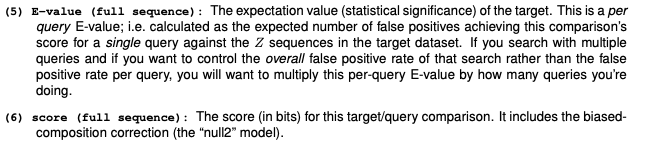

Distinction between e-value and score.

In [ ]:
common = pd.read_csv("Soy_NLRome_GeneTable.txt", sep='\t')
common

,Gene,Clade_0,Clade_1,Clade_2,Clade_3,Clade,Ecotype,Allele,File,HV
0,GWHPACEA009211,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACEA,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
1,W05_GLYSO_03G006025_1_P,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,W05,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
2,GWHPACEK008274,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACEK,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
3,GWHPACED008491,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,GWHPACED,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
4,GLYMA_ZH13_03G036200_1_P,Int7287_409,Int7287_409_656_R_36,Int7287_409_656_R_36,NaN,Int7287_409_656_R_36,ZH13,1,RAxML_tree_pbNB-ARC/Clade_Refinement_1/Int7287...,0
...,...,...,...,...,...,...,...,...,...,...
6977,GWHPACEN024267,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACEN,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6978,GWHPACDZ024107,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACDZ,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6979,GWHPACED023555,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,GWHPACED,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0
6980,W05_GLYSO_06G016310_1_P,Int11805_6,Int11805_6,NaN,NaN,Int11805_6,W05,1,RAxML_tree_pbNB-ARC/Initial_Clades/Int11805_6.afa,0


In [ ]:
final_hv = final.set_index("Clade").join(common[["Clade", "HV", "File"]].groupby("Clade").agg(max), how = 'left', rsuffix = "_other").sort_values("bitscore", ascending = False)

In [ ]:
final_hv

,bias,bitscore,evalue,HV,File
Clade,,,,,
Int11890_361_405_R_36_64_L_31,0.1,1516.6,0.000000e+00,1,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_405_R_36_64_L_31,8.6,1184.9,0.000000e+00,1,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_455_R_50_61_R_13,5.8,1101.3,0.000000e+00,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_628_R_48_55_R_14_19_R_9,9.4,1035.0,0.000000e+00,0,RAxML_tree_pbNB-ARC/Clade_Refinement_3/Int1189...
Int11890_361_504_R_81_85_L_10,5.5,991.3,2.600000e-302,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
...,...,...,...,...,...
Int9024_309_319_R_168_305_R_9,0.0,-4.0,9.600000e-02,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int9024...
Int11890_361_504_R_81_85_L_10,0.0,-4.1,1.200000e-01,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int12744_100_122_R_56_82_R_27,0.0,-4.2,9.000000e-02,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1274...


In [ ]:
best_afa = final_hv.iloc[0,:]["File"]
!mafft --add {jobname}.fasta --keeplength {best_afa} > {jobname}.updated.afa


nadd = 1
nthread = 0
stacksize: 8192 kb
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 32
done.

Constructing a UPGMA tree (efffree=0) ... 
   30 / 32
done.

Progressive alignment 1/2... 
STEP     1 / 31 f
done.

Making a distance matrix from msa.. 
    0 / 32
done.

Constructing a UPGMA tree (efffree=1) ... 
   30 / 32
done.

Progressive alignment 2/2... 
STEP     1 / 31 f
done.

disttbfast (aa) Version 7.310 alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyregion option.



In [ ]:
ls

All_Clades.hmm                    Soy_NLRome/
best_afa_f.afa                    Soy_NLRome_GeneTable.txt
Clade_HMM/                        test_35fc2.fasta
condacolab_install.log            test_35fc2.tbl.out
epa_info.log                      test_59d1d.fasta
epa_result.jplace                 test_59d1d.tbl.out
epa_result.newick                 test_59d1d.updated.afa
{jobname}.updated.afa             test_81cc3.fasta
Minimal_Chimera_Entropy_Script.R  test_81cc3.tbl.out
query.fasta                       test_cf59c.fasta
RAxML_tree_pbNB-ARC/              test_cf59c.tbl.out
reference.fasta


In [ ]:
!conda install -c bioconda epa-ng

Solving environment: / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - epa-ng


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    epa-ng-0.3.8               |       h9a82719_1         1.4 MB  bioconda
    ------------------------------------------------------------
                                           Total:         1.4 MB

The following NEW packages will be INSTALLED:

  epa-ng             bioconda/linux-64::epa-ng-0.3.8-h9a82719_1



epa-ng-0.3.8         | 1.4 MB    | : 100% 1.0/1 [00:00<00:00,  1.36it/s]
Preparing transaction: | done
Verifying transaction: - done
Executing transaction: | done


In [ ]:
clade_oi = common[common["File"] == best_afa].iloc[0,:]["Clade"]
tree_oi = best_afa[:best_afa.find("Int")] + "RAxML_bestTree." + clade_oi + ".Raxml.out"
raxml_info_oi = best_afa[:best_afa.find("Int")] + "RAxML_info." + clade_oi + ".Raxml.out"

In [ ]:
!epa-ng --split {best_afa} {jobname}.updated.afa --tree {tree_oi} --model {raxml_info_oi}

INFO Splitting files based on reference: RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int11890_361_405_R_36_64_L_31.afa
terminate called after throwing an instance of 'std::runtime_error'
  what():  File './query.fasta' already exists. If you want to allow overwriting of existing files, activate Options::allow_file_overwriting() first.


In [ ]:
!cut -f1 -d ' ' {best_afa} > best_afa_f.afa

In [ ]:
cat best_afa_f.afa

>GLYMA_ZH13_16G186900_1_P
-----------------------------------------------------MAWGSRS
SS-------------------SSSNYD-------------VFLSFRGEDTRHAFTGHLY-
----------------KALHD---------------------------------------
----KGIHTFIDD-----------------------------------------------
------------------------------------------------------------
------------EKLQRGEEITPAL-------------MEAIQDSRVAITVLSERY----
-----------ASSSF--------------------------------------------
------------------------------------------------------------
-----------------------CLDELATIL--DQRKRLL-------------------
-------------VIPVFYKVDPSD-----------------------------------
------------------------------------------------------------
VRYQK-------------------------------------GSYG--------------
-------EALAKLETRYQH---------------------------------DPEKLQKW
---------------------------------------------KMALKQV----ADLS
GYHFKEG--DGYEFNFIEKIVEQVSREINPRTLHVADYPVGLESRVLDVRRLLDAGSDDG
VHMIGIHGMGGVGKSTLARAVYNELIIAEKFDGLCFLANVRENSNTH-RLEHLQEKLLL

In [ ]:
!epa-ng --ref-msa best_afa_f.afa --tree {tree_oi} -q query.fasta --model {raxml_info_oi} --redo

INFO Selected: Output dir: ./
INFO Selected: Query file: query.fasta
INFO Selected: Tree file: RAxML_tree_pbNB-ARC/Clade_Refinement_2/RAxML_bestTree.Int11890_361_405_R_36_64_L_31.Raxml.out
INFO Selected: Reference MSA: best_afa_f.afa
INFO Selected: Automatic switching of use of per rate scalers
INFO Selected: Preserving the root of the input tree
INFO Selected: Specified model file: RAxML_tree_pbNB-ARC/Clade_Refinement_2/RAxML_info.Int11890_361_405_R_36_64_L_31.Raxml.out
INFO     ______ ____   ___           _   __ ______
        / ____// __ \ /   |         / | / // ____/
       / __/  / /_/ // /| | ______ /  |/ // / __  
      / /___ / ____// ___ |/_____// /|  // /_/ /  
     /_____//_/    /_/  |_|      /_/ |_/ \____/ (v0.3.8)
INFO Using model parameters:
INFO    Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.602224 (user),  weights&rates: (0.25,0.0535671) (0.25,0.313506) (0.25,0.882449) (0.25,2.75048) 
        Base frequencies (user): 0.076748 0.051691 0.042645 0.051544 0.019803 

In [ ]:
ls

All_Clades.hmm                    Soy_NLRome/
best_afa_f.afa                    Soy_NLRome_GeneTable.txt
Clade_HMM/                        test_35fc2.fasta
condacolab_install.log            test_35fc2.tbl.out
epa_info.log                      test_59d1d.fasta
epa_result.jplace                 test_59d1d.tbl.out
epa_result.newick                 test_59d1d.updated.afa
{jobname}.updated.afa             test_81cc3.fasta
Minimal_Chimera_Entropy_Script.R  test_81cc3.tbl.out
query.fasta                       test_cf59c.fasta
RAxML_tree_pbNB-ARC/              test_cf59c.tbl.out
reference.fasta


In [ ]:
# from google.colab import files
# files.download('epa_result.jplace')

In [ ]:
!conda install -c bioconda gappa

Solving environment: | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gappa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gappa-0.7.1                |       h9a82719_1         1.6 MB  bioconda
    ------------------------------------------------------------
                                           Total:         1.6 MB

The following NEW packages will be INSTALLED:

  gappa              bioconda/linux-64::gappa-0.7.1-h9a82719_1



gappa-0.7.1          | 1.6 MB    | : 100% 1.0/1 [00:00<00:00,  1.33it/s]               
Preparing transaction: | done
Verifying transaction: - done
Executing transaction: | done


In [ ]:
ls

All_Clades.hmm                    Soy_NLRome/
best_afa_f.afa                    Soy_NLRome_GeneTable.txt
Clade_HMM/                        test_35fc2.fasta
condacolab_install.log            test_35fc2.tbl.out
epa_info.log                      test_59d1d.fasta
epa_result.jplace                 test_59d1d.tbl.out
epa_result.newick                 test_59d1d.updated.afa
{jobname}.updated.afa             test_81cc3.fasta
Minimal_Chimera_Entropy_Script.R  test_81cc3.tbl.out
query.fasta                       test_cf59c.fasta
RAxML_tree_pbNB-ARC/              test_cf59c.tbl.out
reference.fasta


In [ ]:
!gappa examine graft --jplace-path ./

                                              ....      ....  
                                             '' '||.   .||'   
                                                  ||  ||      
                                                  '|.|'       
     ...'   ....   ... ...  ... ...   ....        .|'|.       
    |  ||  '' .||   ||'  ||  ||'  || '' .||      .|'  ||      
     |''   .|' ||   ||    |  ||    | .|' ||     .|'|.  ||     
    '....  '|..'|'. ||...'   ||...'  '|..'|.    '||'    ||:.  
    '....'          ||       ||                               
                   ''''     ''''   v0.7.1 (c) 2017-2021
                                   by Lucas Czech and Pierre Barbera

Invocation:                        gappa examine graft --jplace-path ./
Command:                           gappa examine graft

Input:
  --jplace-path                    ./

Settings:
  --fully-resolve                  false
  --name-prefix

Output:
  --out-dir                        .
  --file-prefix     

In [ ]:
ls

All_Clades.hmm                    Soy_NLRome/
best_afa_f.afa                    Soy_NLRome_GeneTable.txt
Clade_HMM/                        test_35fc2.fasta
condacolab_install.log            test_35fc2.tbl.out
epa_info.log                      test_59d1d.fasta
epa_result.jplace                 test_59d1d.tbl.out
epa_result.newick                 test_59d1d.updated.afa
{jobname}.updated.afa             test_81cc3.fasta
Minimal_Chimera_Entropy_Script.R  test_81cc3.tbl.out
query.fasta                       test_cf59c.fasta
RAxML_tree_pbNB-ARC/              test_cf59c.tbl.out
reference.fasta


ABOVE ENDS THE PROCESS TO FIND THE TREE. BELOW WE FIND THE SHANNON ENTROPY FOR CHIMERA.

In [ ]:
final_hv

,bias,bitscore,evalue,HV,File
Clade,,,,,
Int11890_361_405_R_36_64_L_31,0.1,1516.6,0.000000e+00,1,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_405_R_36_64_L_31,8.6,1184.9,0.000000e+00,1,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_455_R_50_61_R_13,5.8,1101.3,0.000000e+00,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int11890_361_628_R_48_55_R_14_19_R_9,9.4,1035.0,0.000000e+00,0,RAxML_tree_pbNB-ARC/Clade_Refinement_3/Int1189...
Int11890_361_504_R_81_85_L_10,5.5,991.3,2.600000e-302,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
...,...,...,...,...,...
Int9024_309_319_R_168_305_R_9,0.0,-4.0,9.600000e-02,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int9024...
Int11890_361_504_R_81_85_L_10,0.0,-4.1,1.200000e-01,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1189...
Int12744_100_122_R_56_82_R_27,0.0,-4.2,9.000000e-02,0,RAxML_tree_pbNB-ARC/Clade_Refinement_2/Int1274...


In [ ]:
is_hv = final_hv.iloc[0,:]["HV"] == 1
!Rscript Minimal_Chimera_Entropy_Script.R -f {jobname}.updated.afa -n test

In [ ]:
ls ./Test/test_/

test_.ChimeraEntropy.txt  test_Entropy_MaskedNG.pdf
